In [1]:
!pip install pandas-summary ipython fastai==0.7 treeinterpreter

    100% |████████████████████████████████| 122kB 3.9MB/s ta 0:00:01
    100% |████████████████████████████████| 496.4MB 77kB/s  eta 0:00:01  7% |██▌                             | 38.0MB 42.0MB/s eta 0:00:11    14% |████▋                           | 70.8MB 36.9MB/s eta 0:00:12██▍                          | 82.8MB 37.7MB/s eta 0:00:11    26% |████████▌                       | 131.5MB 35.6MB/s eta 0:00:11    31% |██████████                      | 156.2MB 35.7MB/s eta 0:00:10    32% |██████████▎                     | 160.3MB 36.4MB/s eta 0:00:10    44% |██████████████▎                 | 221.4MB 35.5MB/s eta 0:00:08    45% |██████████████▍                 | 223.4MB 35.7MB/s eta 0:00:08��███████▋               | 257.7MB 37.8MB/s eta 0:00:07    52% |████████████████▊               | 259.6MB 6.5MB/s eta 0:00:37    77% |████████████████████████▉       | 384.9MB 32.0MB/s eta 0:00:04    79% |█████████████████████████▍      | 394.7MB 35.5MB/s eta 0:00:03    82% |██████████████████████████▌     | 

  Found existing installation: torch 1.0.0
    Uninstalling torch-1.0.0:
      Successfully uninstalled torch-1.0.0
  Found existing installation: fastai 1.0.39
    Uninstalling fastai-1.0.39:
      Successfully uninstalled fastai-1.0.39
You are using pip version 18.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
import IPython

from sklearn import metrics

In [5]:
PATH = '../input/train/'
# Kaggle Kernel
# !mkdir data && cp -r ../input/train data/bulldozer
# !ls data/bulldozer -a

In [6]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, parse_dates=["saledate"])
# ! ls ../input/train
# df_raw = pd.read_feather('tmp/bulldozers-raw')

In [7]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)
display_all(df_raw.tail().transpose())

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [8]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [29]:
?add_datepart
??proc_df

In [9]:
# df_raw.saledate.head
add_datepart(df_raw, 'saledate')

In [13]:
# df_raw.saleYear.head()
# display_all(df_raw.tail().transpose())
train_cats(df_raw)
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [14]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [15]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

In [16]:
x, y, nas = proc_df(df_raw, 'SalePrice')

In [17]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(x, y)
m.score(x, y)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 51s, sys: 716 ms, total: 1min 52s
Wall time: 58.2 s


0.9831106004787267

In [21]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()
n_valid = 12000
n_trn = len(x) - n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(x, n_trn)
y_train, y_valid = split_vals(y, n_trn)
X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [22]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())
def print_score(m):
    res = [rmse(m.predict(X_train), y_train),
           rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [23]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(x, y)
m.score(x, y)
print_score(m)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 54s, sys: 592 ms, total: 1min 54s
Wall time: 59.2 s
[0.09028536071699178, 0.09357194673161183, 0.9829639266563921, 0.9843635088342559]


In [ ]:
# df_raw.SalePrice = np.log(df_raw.SalePrice)

In [24]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

''

In [30]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)
# ??proc_df

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 50s, sys: 524 ms, total: 1min 51s
Wall time: 57.9 s
[0.09031748655388638, 0.24778457449929797, 0.9829518007595569, 0.8903530622985404]


In [ ]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
draw_tree(m.estimators_[0], df_trn, precision=3)

In [ ]:
?IPython

In [ ]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

In [31]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([9.10498, 8.9872 , 8.95545, 9.21034, 9.04782, 9.25913, 9.39266, 8.9872 , 8.9872 , 9.10498]),
 9.103695257634037,
 9.104979856318357)

In [ ]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, 
                          oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [40]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
set_rf_samples(20000)

In [41]:
fi = rf_feat_importance(m, X_train); fi[:10]

,cols,imp
5,YearMade,0.171280
37,Coupler_System,0.117558
13,ProductSize,0.098442
14,fiProductClassDesc,0.086350
2,ModelID,0.060948
63,saleElapsed,0.050682
38,Grouser_Tracks,0.046357
10,fiSecondaryDesc,0.041361
19,Enclosure,0.034554
39,Hydraulics_Flow,0.033735


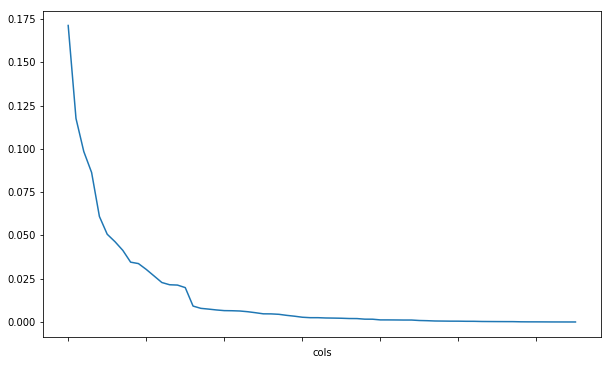

In [42]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [47]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

25

In [48]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

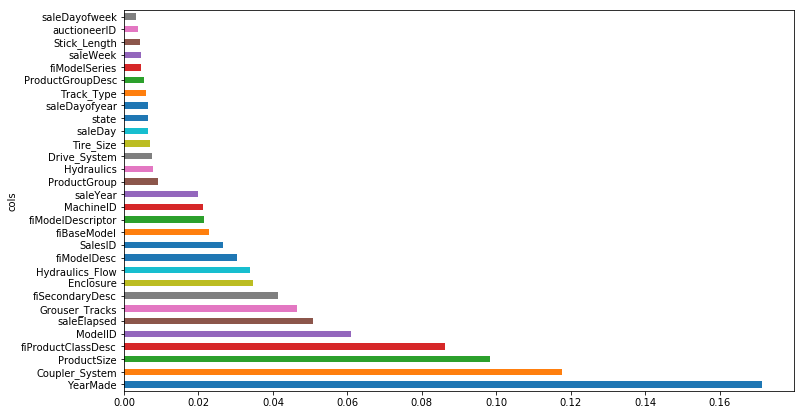

In [44]:
 def plot_fi(fi):
  return fi.plot('cols','imp','barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);


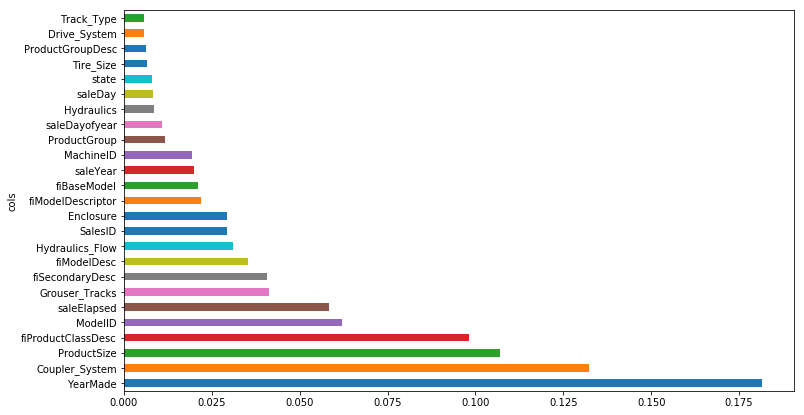

In [54]:
set_rf_samples(50000)


X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

In [37]:
from treeinterpreter import treeinterpreter as tl

In [55]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [57]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,        665, 1284595200,          0,          0,
                 1,          0,       3232,    4364751,       1111,          0,    2300944,       2010,
                 4,         12,          0,          0,         16,         35,        259,          2,
                 4]])

In [58]:
prediction, bias, contributions = tl.predict(m, row)

In [59]:
contributions[0].sum()

-0.8315016576780854

In [60]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [62]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_
fi = rf_feat_importance(m, x); fi[:10] 

,cols,imp
11,SalesID,0.778785
5,saleElapsed,0.141575
14,MachineID,0.039227
15,saleYear,0.024477
22,saleDayofyear,0.007308
12,fiBaseModel,0.002048
4,ModelID,0.001484
0,YearMade,0.001259
10,fiModelDesc,0.001130
1,Coupler_System,0.000684


In [63]:
feats=['SalesID', 'saleElapsed', 'MachineID']

(X_train[feats]/1000).describe()

(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [66]:
x.drop(feats, axis=1, inplace=True)

m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9857824867559988

In [69]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [72]:
m = RandomForestClassifier(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs = -1, oob_score = True)
m.fit(x, y)
m.oob_score_

0.9999850420691805

In [74]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
11,SalesID,0.738735
5,saleElapsed,0.143489
14,MachineID,0.050393
15,saleYear,0.039952
22,saleDayofyear,0.014152
10,fiModelDesc,0.003295
12,fiBaseModel,0.002806
4,ModelID,0.001773
0,YearMade,0.001660
7,fiSecondaryDesc,0.000879


In [79]:
feats = ['SalesID', 'saleElapsed', 'MachineID']

In [80]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [81]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [83]:
x.drop(feats, axis = 1, inplace = True)

In [85]:
m = RandomForestClassifier(n_estimators = 40, 
                            min_samples_leaf = 3,
                            max_features = 0.5,
                            n_jobs = -1,
                            oob_score = True
                           )
m.fit(x, y)
m.oob_score_

0.9857326269866001

In [86]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
12,saleYear,0.296970
19,saleDayofyear,0.289892
4,ModelID,0.059000
17,saleDay,0.051253
0,YearMade,0.042102
18,state,0.039622
9,fiModelDesc,0.036567
10,fiBaseModel,0.029679
7,Enclosure,0.025786
3,fiProductClassDesc,0.022656


In [87]:
set_rf_samples(50000)

In [89]:
feats = ['SalesID', 
         'saleElapsed',
         'MachineID',
         'age',
         'YearMade',
         'saleDayofYear'
        ]

In [90]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20702287075354417, 0.2450901868960485, 0.9104281633826385, 0.8927246796847661, 0.8941378956203997]


In [91]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20758068930922186, 0.24175940710930577, 0.9099448143988438, 0.895620613996624, 0.8940034885486858]
saleElapsed
[0.21030097357990662, 0.24715340950661582, 0.9075690551390034, 0.8909109434156841, 0.8910715064029033]
MachineID
[0.20538870695718126, 0.24249388198923214, 0.9118366776799711, 0.894985432994603, 0.8963522464210287]


KeyError: "['age'] not found in axis"

In [ ]:

reset_rf_samples()